# Motivation

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


**From the Board**<br>
Addressed to _Data Science Ninjas_ <br>

We sit on the board of a company. This company is medium sized and has a reasonable number of employees. Since the founding day of our company, information has been gathering regarding employee satisfaction, annulized average of monthly hours, number of projects, and if the employee has quit. 

Turnover is becoming an issue. What information can be extracted from the records? The board wants to implement preventive actions that boost employee satisfaction and reduce turnover rates. Where should the board direct company effort and resources to meet this demands?<br>
<hr>
**Data Science Ninjas**<br>
Plan of action<br>
1. Inspect
    1. Quick numerics and visualization that provide insights
2. Top features of premature exit?
    1. Machine learning; ensemble learning for feature importances. _! BEWARE OF CORRELATIONS !_
    2. Machine learning; train model and implement alert systems. Automate.

<hr>

# Import the data

Data can be hosted locally or within company data warehousing systems. This example utilizes the [`Human Resource Data`](https://www.kaggle.com/ludobenistant/hr-analytics/downloads/HR_comma_sep.csv) provided by [Medium](https://medium.com/towards-data-science).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# locally hosted CSV
df = pd.read_csv('HR_comma_sep.csv')
df.rename(columns={'sales':'dept'}, inplace=True)

In [3]:
# Numerical information about features of interests
cols = ['satisfaction_level', 'number_project', 'average_montly_hours', 'time_spend_company']
rows = ['mean', 'std']
df.describe().ix[rows, cols]

,satisfaction_level,number_project,average_montly_hours,time_spend_company
mean,0.612834,3.803054,201.050337,3.498233
std,0.248631,1.232592,49.943099,1.460136


In [4]:
# Categorial information
df[['dept', 'salary']].describe()

,dept,salary
count,14999,14999
unique,10,3
top,sales,low
freq,4140,7316


# High level inspection

An abundance of questions exists that could produce a variety of insights. Are more employees leaving given departments (total and percentage)? What, if any, are the effects of salary? How strongly does employee satisfaction influence the decision to leave?

Before beginning any line of questioning, let us look at the probability distributions utilizing [Violin plots](https://en.wikipedia.org/wiki/Violin_plot). The x-axis will be categorical; representing unique departments. The y-axis represents average monthly hours worked. The colors represent employees who have or have not left the company prematurely. Blue is an active employee and green an inactive employee. The dashed lines indicate the interquartile distances.

The Violin plots are also scaled to the number of observation in each bin. This provides enchanes the visual by exposing the proportionalities of each displayed area.

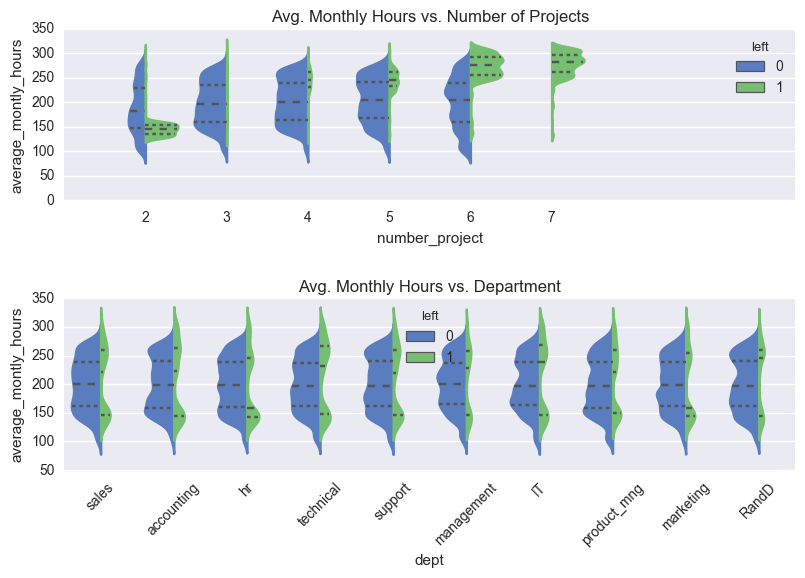

In [5]:
# Instantiate figure object
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5))
f.tight_layout(h_pad=5)




# average_monthly_hours vs number_project
plt.sca(ax1)
sns.violinplot(data=df, x='number_project', y='average_montly_hours', hue='left', 
                    split=True, inner='quartile', bw=.2, alpha=0.2, 
               palette='muted', scale='count',
               ax=ax1);
ax1.set_title('Avg. Monthly Hours vs. Number of Projects');
ax1.set_ybound([0, 350])
ax1.set_xbound([-1, 8])



# average_monthly_hours vs number_project
sns.violinplot(data=df, x='dept', y='average_montly_hours', hue='left', 
                    split=True, scale='count', inner='quartile', bw=.2, 
               palette='muted',
               ax=ax2);
plt.sca(ax2)
plt.xticks(rotation=45)
ax2.set_title('Avg. Monthly Hours vs. Department');


What information is avaialbe from the above Violin plots? 
- **Department Localization**
    1. The general behavioural trends across departments appear similar. There is no remarkable indication that a single department should be inspected above others.
- **Average monthly hours**
    1. _Blue_: has_left = False - Monthly averages remain near 200 hours
    2. _Green_: has_left = True - Monthly average ALL above 200 hours
- **Projects**
    1. The range of [3,5] appear to be the employee sweet spot for project work. This may be correlated to employee satisfication. 
    2. Two projects show the lowest average hours worked for those employees who exited the company. What reasons contribute to an employee only working on two projects? How does `employment_duration` and `satisfaction` correlate to the low hours and project workload?


In [6]:
# Extract average working hours for current employees and former
# indexed on the number of projects
agg = df.groupby(['number_project', 'left'])['average_montly_hours'].mean()

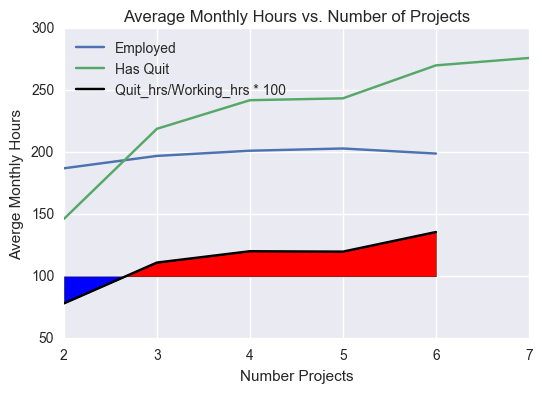

In [7]:
projects_working, still_working = agg.xs(0, level=1).reset_index().values.T
projects_left, has_left = agg.xs(1, level=1).reset_index().values.T

# Obtain ratio for comparision
ratio = has_left[:-1] / still_working * 100

# Create plots
leg1, = plt.plot(projects_working, still_working, label='Employed')
leg2, = plt.plot(projects_left, has_left, label='Has Quit')
leg3, = plt.plot(projects_working, ratio, color='black', label='Quit_hrs/Working_hrs * 100')
# Legend
plt.legend(handles=[leg1, leg2, leg3], loc='upper left');
# Fill between to emphasize hour differences
plt.fill_between(projects_working, 100, ratio, where=ratio >= 100, facecolor='red', interpolate=True)
plt.fill_between(projects_working, 100, ratio, where=ratio < 100, facecolor='blue', interpolate=True)
plt.xlabel('Number Projects')
plt.ylabel('Averge Monthly Hours')
plt.title('Average Monthly Hours vs. Number of Projects')
plt.show();

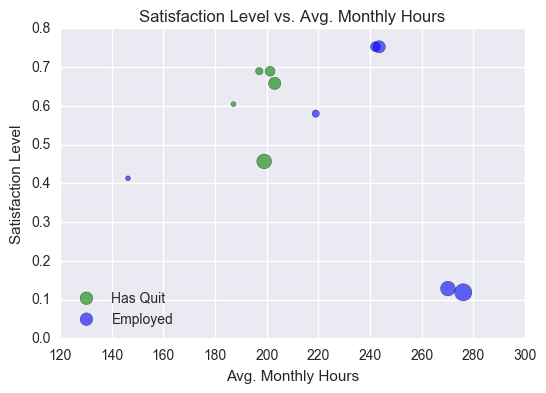

In [8]:
# Group and aggregate on mean
sat_lev = df.groupby(['number_project', 'left'])[['average_montly_hours', 'satisfaction_level']].mean()


# Extract the unique project count
project_count = np.unique(sat_lev.index.get_level_values(0).values)
radius = (np.pi * project_count**2)

# Has_Quit & Employed matrices
left = sat_lev.xs(0, level=1).values.T
remain = sat_lev.xs(1, level=1).values.T

# Instantiate the plot
fig = plt.figure()
ax1 = fig.add_subplot(111)

# Add scatter plots to ax1 
ax1.scatter(left[0], left[1], s=radius, label='Has Quit', c='green', alpha=.6)
ax1.scatter(remain[0], remain[1], s=radius, label='Employed', c='blue', alpha=.6)
# Meta information
ax1.set_xlabel('Avg. Monthly Hours')
ax1.set_ylabel('Satisfaction Level')
plt.legend(loc='lower left')
ax1.set_title('Satisfaction Level vs. Avg. Monthly Hours')
plt.show();


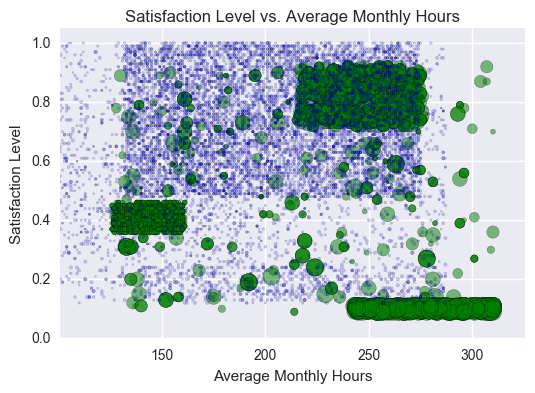

In [9]:
# All values of employees who have left and those that remain
left = df[df['left'] == 1][['satisfaction_level', 'number_project', 'average_montly_hours']].values.T
remain = df[df['left'] == 0][['satisfaction_level', 'number_project', 'average_montly_hours']].values.T

# Plot boundaries
x_min, x_max = df.describe().ix[['min', 'max']]['average_montly_hours'] * 1.05
y_min, y_max = df.describe().ix[['min', 'max']]['satisfaction_level'] * 1.05

# Create the figure
fig = plt.figure()
ax1 = fig.add_subplot(111)

# Add scatter plots to each axis
ax1.scatter(left[2], left[0], s=np.pi * left[1]**2, alpha=0.5, c='green', label='Has Quit')
ax1.scatter(remain[2], remain[0], s=remain[1], alpha=0.2, c='blue', label='Employed')

# Set axis and labels
ax1.set_xlim([x_min, x_max]);
ax1.set_ylim([0, y_max]);
ax1.set_xlabel('Average Monthly Hours')
ax1.set_ylabel('Satisfaction Level')
ax1.set_title('Satisfaction Level vs. Average Monthly Hours')
plt.show();

Arming ourselves with the global satisfaction levels, average monthly hours, and number of projects the general _Satisfaction Space_ can be visualized. The scatter plot above indicates high levels of clusting in three distinct areas. Further questions could be:
1. What features are unique to those clusters?
2. Do correlations exists between clusters?

This post will not be delving into the questions. With the basic visuals created, let us move into feature importances.

# Feature importance

In [46]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import  DecisionTreeClassifier

# Create encoder maps for categorical data
department_map = { val:idx for idx, val in enumerate(df['dept'].drop_duplicates().values)}
salary_map = {val:idx for idx, val in enumerate(df['salary'].drop_duplicates().values)}

# Apply encoder maps to categorical data
df['dept'] = df['dept'].apply(lambda x: department_map.get(x, None))
df['salary'] = df['salary'].apply(lambda x: salary_map.get(x, None))

# OneHotEncoding of categorical data
data_enc = pd.get_dummies(df, columns=['dept', 'salary'])


# classes
y = data_enc['left']

# data
if 'left' in data_enc.columns:
    data_enc = data_enc.drop('left', axis=1)

X = StandardScaler().fit_transform(data_enc)


# Shapes
N, D = X.shape
K = 2
T = np.zeros((N, K))
for i in range(N):
    T[i, y[i]] = 1


X_train, X_test, y_train, y_test = train_test_split(X, T, test_size=.3, random_state=42)

In [47]:
print('Training')
print('\tShape of X_train: ', X_train.shape)
print('\tShape of y_train: ', y_train.shape)
print('Testing')
print('\tShape of X_test: ', X_test.shape)
print('\tShape of y_test: ', y_test.shape)

Training
	Shape of X_train:  (10499, 20)
	Shape of y_train:  (10499, 2)
Testing
	Shape of X_test:  (4500, 20)
	Shape of y_test:  (4500, 2)


In [51]:
# Build the forest
forest = ExtraTreesClassifier(n_estimators=100, random_state=42)
tree = DecisionTreeClassifier() 

# Train the ForestClassifier
forest.fit(X_train, y_train)
tree.fit(X_train, y_train)

# Test
print('forest: ', np.mean(forest.predict(X_test) == y_test))
print('tree: ', np.mean(tree.predict(X_test) == y_test))

forest:  0.981444444444
tree:  0.973333333333


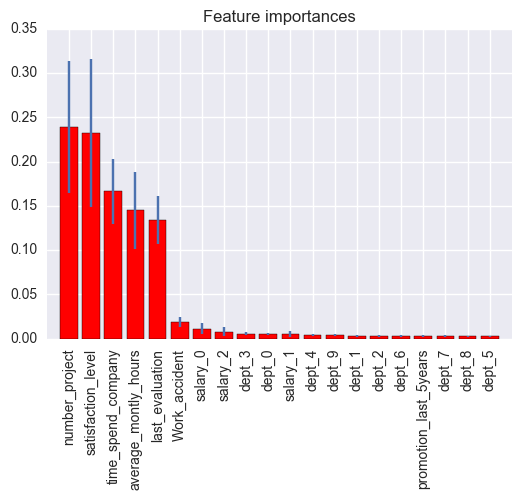

In [64]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

#for f in range(X_train.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), data_enc.columns[indices].values, rotation=90)

plt.xlim([-1, X_train.shape[1]])
plt.show()

# What we have learned

**Word of Caution** No effort has been made to decouple the input. The resulting values of feature importances may be linearly dependent and not linearly independent. That basically implies that one feature implies another. 

1. Numer of Projects
2. Satisfaction level
3. Time with company
4. Average monthly hours